# Probabilistic Methods of Anomaly Detection (Discrete)

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

## Acquire Data

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.tail()

,ip,timestamp,request_method,status,size,destination,request_agent
13973,97.105.19.58,[17/Apr/2019:12:55:14 +0000],"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
0,95.31.18.119,[21/Apr/2019:10:02:41+0000],GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
1,95.31.16.121,[17/Apr/2019:19:36:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2,97.105.15.120,[18/Apr/2019:19:42:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0
3,97.105.19.58,[19/Apr/2019:19:42:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,200,2056327,NaN,python-requests/2.21.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [13]:
df.loc[df['destination'].notnull()]

,ip,timestamp,request_method,status,size,destination,request_agent
174,97.105.19.58,[16/Apr/2019:19:38:16 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/V1/HiZach!""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
566,97.105.19.58,[16/Apr/2019:19:44:04 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=0""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
583,97.105.19.58,[16/Apr/2019:19:44:16 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=1""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
596,97.105.19.58,[16/Apr/2019:19:44:24 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=1""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
602,97.105.19.58,[16/Apr/2019:19:44:28 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=2""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
618,97.105.19.58,[16/Apr/2019:19:44:38 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=999""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
676,97.105.19.58,[16/Apr/2019:19:45:20 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/items?page=0""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
1117,97.105.19.58,[16/Apr/2019:19:49:41 +0000],"""GET /api/v1//api/v1/items?page=2 HTTP/1.1""",200,162,"""http://localhost:8889/notebooks/timeseries_ac...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
1123,97.105.19.58,[16/Apr/2019:19:49:43 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1//api/v1/items?...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
1146,97.105.19.58,[16/Apr/2019:19:49:53 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1//api/v1/items""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."


### Parse Datetime:

In [14]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [15]:
df

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""
...,...,...,...,...,...,...
2019-04-17 12:55:14+00:00,97.105.19.58,"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
2019-04-21 10:02:41+00:00,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0


### Cleanup Text:

In [16]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [17]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


### Add Variable - Converting bytes to mb:

In [18]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [19]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Finding anomalies in already existing data:

We can easily see some anomalies around IP addresses.

In [20]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)
ip_df

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,70.121.214.34,2,0.000143
7,52.87.230.102,2,0.000143
8,35.175.171.137,2,0.000143
9,35.174.209.2,1,0.000072


In [21]:
# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,70.121.214.34,2,0.000143
7,52.87.230.102,2,0.000143
8,35.175.171.137,2,0.000143
9,35.174.209.2,1,0.000072
10,97.105.15.120,1,0.000072
11,3.92.201.136,1,0.000072
12,52.91.30.150,1,0.000072
13,95.31.18.119,1,0.000072


22
               ip  ip_count  ip_proba
12   52.91.30.150         1  0.000072
13   95.31.18.119         1  0.000072
14  34.229.70.250         1  0.000072
15  54.145.52.184         1  0.000072
16   45.23.250.16         1  0.000072
17  34.207.64.242         1  0.000072
18  54.172.14.223         1  0.000072
19  52.90.165.200         1  0.000072
20   3.88.129.158         1  0.000072
21   95.31.16.121         1  0.000072


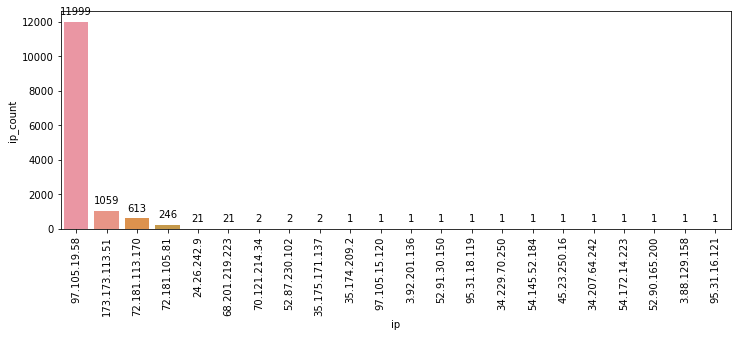

In [22]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives.

### Establish Baseline:

In [ ]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]
train

### Compute probabilities based on train sample:

In [ ]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

### Merge probabilities with all data (train + new data):

Where the IP address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [ ]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.ip_proba.value_counts()

## Conditional Probabilities: Probabilities using 2 discrete variables

### Probability of Status given IP Address:
If we are looking for an unexpected status (like authentication failure) from a known/common IP address.

In [ ]:
ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [ ]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

### Add these probabilities to original events to detect anomalous events:

In [ ]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [ ]:
df.head()

In [ ]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.title('Probability of Seeing a status given an IP by probability of seeing that IP address')
plt.xlabel('Probability of seeing the status given the IP')
plt.ylabel('Probability of seeing this given IP address')

## Exercise

### Discrete Data + Probability
Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.